# Fun with Funnels
### By Alex Frieder

## Introduction

Imagine you were just hired by a company that has runs an online marketplace. Their website allows users to sign up for an account, log in to their account, search for products, leave reviews for products, and purchase products. They've hired you because their sales numbers are down, and they want you to figure out what's going wrong with their website and how to improve it. 

Thankfully, they have a complete record of the actions every visitor to their website has ever taken stored in a database. Ideally, every visitor should log in to an account, search for a product, purchase that product, and then leave a review for that product. This series of steps is called a _funnel_, and using _funnel analysis_, we can figure out which step needs the most improvement. We say a user has _converted_ if they make it through the funnel, and we thus call the total percentages of users who convert the _conversion rate_. 

Consider two graphs of our funnel on two different data sets:

<img src='https://raw.githubusercontent.com/afrieder/practical-data-science/master/intro_funnel_left.png' width="400px" style="display: block;float: left"/><img src='https://raw.githubusercontent.com/afrieder/practical-data-science/master/intro_funnel_right.png' width="400px" style="display: block"/>

The plot on the left says that 1,000 people did Log In. Of those, 90% then did Search. Of _those_ 91.11% did Purchase. Finally, of those, 14.02% did Review. This means of the initial 1,000 people, 11.50% did all four events in that sequence. Note that doesn't mean these people did _only_ these events. If someone logged in, purchased something, _then_ searched, purchased, and reviewed, they still count as a successful conversion. But the events must be in that order. So if someone searched, purchased, reviewed, and _then_ logged in, they only count towards the first step, since they never searched after logging in.

The results of funnel analysis are very actionable, that is, they often give insight into particular things that can be improved. For example, in the left funnel above, most people make it mostly through the funnel, but drop off after purchasing products and before leaving reviews, then maybe we should consider emailing people sometime after they purchase their product, asking them to leave a review. But if most people don't even get to purchasing a product after searching for a product as in the right funnel, then maybe we might want to look into our checkout screen. If we had more events like "enter credit card info", "view purchase screen", and "apply coupon", we could get more insight into what exactly the user did before stopping. As you can see from this, more granular events can lead to more precise action items from funnel analysis.

## Creating Funnels

The plots above can be created only using Matplotlib's bar plot. We'll use test data stored in a SQLite database file. These libraries should already be installed with the Anaconda package. We'll also use `namedtuple`s to easily store our event data, `partial` to pre-set some function values, and `product` to generate cartesian products of arbitrary size.

In [1]:
from collections import namedtuple
Event = namedtuple('Event', ['event', 'timestamp'])

from functools import partial
from itertools import product

import matplotlib.pyplot as plt
%matplotlib inline
BAR_WIDTH = 0.8

import sqlite3
conn = sqlite3.connect('user_data.db')
conn.row_factory = sqlite3.Row

Now we want to write a basic function `funnel_plt` that takes in the labels for the events and the number of people who have made it that far into the funnel and plots the kind of graphs we've made above. 

In [2]:
def funnel_plt(events, num_completed):
    """ Plots the funnel represented by the arguments
    
    Args:
        events (list): A list of labels for each event
        num_completed (list): A list of the number of users who completed each event. 
                              Must be the same length as events
    """
    # For each event (except the first) we want to calculate the fraction of people
    # who did this event out of the people who did the previous event.
    event_labels = [events[0]]
    for i in range(1, len(num_completed)):
        percent_completed = float(num_completed[i]) / num_completed[i - 1] if num_completed[i - 1] > 0 else 0
        event_labels.append('{}\n({:.2%})'.format(events[i], percent_completed))

    plt.bar(range(len(num_completed)), num_completed, BAR_WIDTH, color='blue')
    plt.xlabel('Event')
    plt.ylabel('Number Completed')

    total_conversion_rate = float(num_completed[-1]) / num_completed[0]
    plt.title('Funnel of {}\nTotal conversion rate: {:.2%}'.format(' -> '.join(events), total_conversion_rate))
    plt.xticks([i + BAR_WIDTH/2 for i in range(len(events))], event_labels)

    plt.show()

For example, the left funnel above was created by calling:

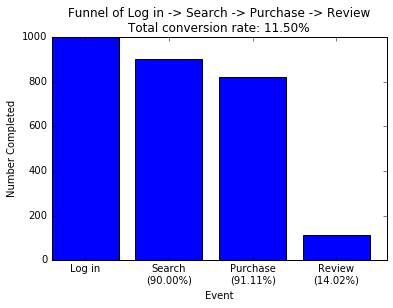

In [3]:
funnel_plt(['Log in', 'Search', 'Purchase', 'Review'], [1000, 900, 820, 115])

Now we have to figure out how to calculate the `num_completed` list from our database. First we need to determine how far a single user went into the funnel. Let's assume we're given all the relevant events a user did as a list of pairs of numbers. In this example, we can imagine 0 representing Log In, 1 representing Search, 2 representing Purchase, and 3 representing Review. So for example, if we're calculating the above funnel, if a user did a search at time 10, then a review at time 20, then a log in at time 30, then a search at time 40, and then another log in at time 50, their actions would be represented by the list `[(1, 10), (3, 20), (0, 30), (1, 40), (0, 50)]`. From this, we can calculate how far they went into the funnel as follows:

In [4]:
def funnel_events_for_user(events, len_of_funnel):
    """ Calculates for a given user's events how far they went into the funnel
    
    Args:
        events (list): A list of Events, sorted by the time they occurred, 
                       with the earliest event first
        len_of_funnel (int): The number of events that make up the funnel
    Returns: 
        did_step (list): A list of Booleans where did_step[i] means 
                         the user made it through step i in the funnel
    """
    did_step = [False for i in range(len_of_funnel)]
    step = 0
    for event in events:
        if event.event == step:
            did_step[step] = True
            if step == len_of_funnel:
                # `step` represents which step we're considering, zero-indexed.
                # If it equals `len_of_funnel`, then the user has already
                # completed the entire funnel and we can exit early.
                break
            else:
                step += 1
    return did_step

Additionally, we can write a function that takes all of the users' events and returns the `num_completed` list above by calling `funnel_events_for_user` on each user's data and aggregates the results.

In [5]:
def funnel_events(user_events, len_of_funnel, events_for_user):
    """ Calculates the number of users who completed each step of the funnel
    
    Args:
        user_events (list): A list of each user's events, sorted by the time they occurred, 
                            with the earliest event first
        len_of_funnel (int): The number of events that make up the funnel
    Returns:
        num_completed (list): A list of ints where num_completed[i] is the number 
                              of users in user_events who made it to step i in the funnel
    """
    did_steps = []
    for events in user_events:
        did_steps.append(events_for_user(events, len_of_funnel))
    # Uses that x + True == x + 1 and x + False == x in Python
    merge = lambda accumulated, did_step: [accumulated[i] + did_step[i] for i in range(len_of_funnel)]
    return reduce(merge, did_steps, [0 for _ in range(len_of_funnel)])

## Formatting Database Data

Now we just need to figure out how to get our data into this format. First let's load the database and see how our data is formatted. This database contains randomly generated data meant to simulate how a real-life example might look.

In [6]:
tables = conn.cursor().execute("SELECT name FROM sqlite_master WHERE type='table'")
for table in tables:
    print "table name is: {}".format(table['name'])

    table_sql = conn.cursor().execute("SELECT sql FROM sqlite_master WHERE name = ?", [table['name']])
    print "table {} was created using:\n{}".format(table['name'], table_sql.fetchone()['sql'])

table name is: events
table events was created using:
CREATE TABLE events(user_id BIGINT, timestamp BIGINT, event TEXT)


It appears we have a single table 'events' which contains our events. Let's run some more exploratory analysis on this table.

In [7]:
num_events = conn.cursor().execute("SELECT COUNT(*) AS count FROM events").fetchone()['count']
print 'There are {} events'.format(num_events)

num_users = conn.cursor().execute("SELECT COUNT(DISTINCT user_id) AS count FROM events").fetchone()['count']
print 'There are {} distinct users'.format(num_users)

types_of_events = conn.cursor().execute("SELECT event, COUNT(*) AS count FROM events GROUP BY event")
print 'There are the following events:'
for row in types_of_events:
    print '\t{} appears {} times'.format(row['event'], row['count'])

There are 2503 events
There are 936 distinct users
There are the following events:
	Log in appears 238 times
	Purchase appears 519 times
	Review appears 322 times
	Search appears 1183 times
	Sign up appears 241 times


We can now start building the architecture needed to make funnels out of this data:

In [8]:
def get_events_per_user(events, user_id, conn):
    """ Returns a query that fetches all event rows for user `user_id` 
        with the relevant events replaced with the correct number as `step`
    
    Args:
        events (list): A list of the events we want to fetch
        user_id (int): The user we want to fetch rows for
        conn (sqlite3.Connection) : Connection object corresponding to the database
    Returns:
        events (list): A list of this user's event steps, sorted by the time they occurred, 
                       with the earliest event first
    """
    query_strs = []
    params = []
    for step, event in enumerate(events):
        query_strs.append("""SELECT ? AS step, timestamp FROM events WHERE event = ? AND user_id = ?""")
        params.extend([step, event, user_id])
    inner_query = ' UNION '.join(query_strs)
    
    outer_query = """
        SELECT step, timestamp FROM ({}) inner_query
        ORDER BY timestamp ASC, step DESC
    """.format(inner_query)
    
    results = conn.cursor().execute(outer_query, params)
    return [Event(event=row['step'], timestamp=row['timestamp']) for row in results]

Note that we sort by `timestamp` primarily but also by `step` secondarily. This is very important and allows us to have the same event twice in a single funnel.

Say we want to see what percentage of users come back and make another purchase after their first. This can be represented by the funnel of Purchase -> Purchase. Say we have a user who made a single purchase at time 10. This single purchase gets coded both as a 0 and a 1, since both steps in the funnel are Purchase, and occur at the same `timestamp`. Now our events list for this user could either look like `[(0, 10), (1, 10)]` or `[(1, 10), (0, 10)]` depending on how we order `step`. Note how in the first example, where we've ordered by `step` ascending, this user counts as having completed both steps of the funnel even though they only did a single event. This does not occur in the second example, where we've ordered by `step` descending. In this example, the user will only count as having completed the second step if they had afterwards made another purchase, which is correct.

Now we just have to fetch the rows for every distinct user:

In [9]:
def get_events(events, conn):
    """ Returns a list of event steps for each user in the database
    
    Args:
        events (list): The events in the funnel
        conn (sqlite3.Connection) : Connection object corresponding to the database
        
    Returns:
        user_events (list): A list of each user's events, sorted by the time they occurred,
                            with the earliest event first
    """
    users = conn.cursor().execute('SELECT DISTINCT user_id FROM events')
    return [get_events_per_user(events, user['user_id'], conn) for user in users]

Finally we can write a nice wrapper that fetches the events and plots our funnel:

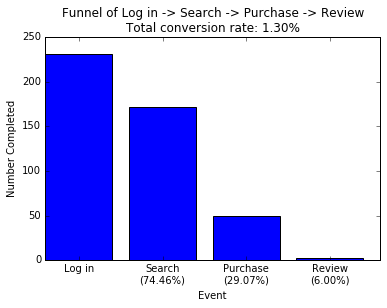

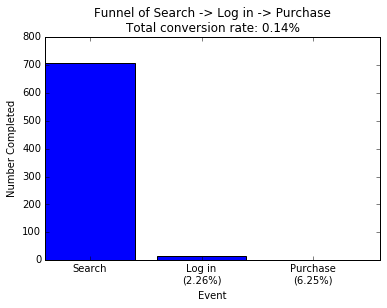

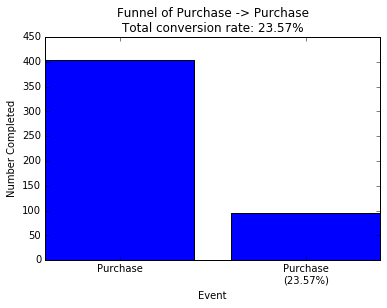

In [10]:
def make_funnel(events, conn):
    """ Fetches data from the db and plots the resulting funnel
    
    Args:
        events (list): The events in the funnel
        conn (sqlite3.Connection) : Connection object corresponding to the database
    """
    user_events = get_events(events, conn)
    num_completed = funnel_events(user_events, len(events), funnel_events_for_user)
    funnel_plt(events, num_completed)

make_funnel(['Log in', 'Search', 'Purchase', 'Review'], conn)
make_funnel(['Search', 'Log in', 'Purchase'], conn)
make_funnel(['Purchase', 'Purchase'], conn)

Now we can start making actionable conclusions from our analysis:

From these three funnels, we can see that our search results page is simply not convincing people to purchase. From the first funnel we see that of the people who logged in and then searched (presumably with the intent of buying something), only 30% actually ended up buying something. From the second funnel we see that of people who searched, only an abysmal 0.14% were convinced to log in and then make a purchase. Finally, from the third funnel we see that of the people who make a purchase, 25% come back and make another purchase, which implies the problem isn't with our purchase page. 

Thus from just these three images on a very high level, after only a few minutes, we can start to get a sense of how people use our website and how we can improve it.

## Time-Bounded Funnels

In all of the examples above, the funnels are taken over the entire range of data. This means that if someone logged in one day, and purchased something two months later, they would be included in a Log in -> Purchase funnel, which we might not want. We can use _time-bounded funnels_ to calculate the conversion rate for people, where the _entire funnel_ must have been completed within some time bound.

Since our `Event` already carries the timestamp information along with it, we can use that to calculate a time-bounded funnel as follows:

In [11]:
def time_bounded_funnel_events_for_user(events, len_of_funnel, bound):
    """ Calculates for a given user's events how far they went into the funnel,
        where the entire funnel must be completed within `bound` time.
    
    Args:
        events (list): A list of Events, sorted by the time they occurred, 
                       with the earliest event first
        len_of_funnel (int): The number of events that make up the funnel
        bound (int): The time bound of the funnel
    Returns:
        did_step (list): A list of Booleans where did_step[i] means 
                         the user made it through step i in the funnel
    """
    last_did_step = [None for i in range(len_of_funnel)]
    for event in events:
        if event.event == 0:
            last_did_step[0] = event.timestamp
        else:
            prev_timestamp = last_did_step[event.event - 1]
            if prev_timestamp is not None and event.timestamp - prev_timestamp < bound:
                last_did_step[event.event] = prev_timestamp
                if event.event == len_of_funnel:
                    break
    return map(lambda step: step is not None, last_did_step)

The algorithm here is very similar to the general funnel algorithm. Instead of simply keeping a Boolean of whether we've gone that far into the funnel or not, we keep track of the timestamp of the most recent funnel to get that far. For an event to be included in the funnel, not only does the previous event have to be reached, but it has to be reached in a funnel starting no longer than `bound` before. Our `funnel_events` function from before takes a generic function to apply to each user's data, so we can write a new `make_funnel` function that can handle time-bounds as well as generic funnels. We could also augment our `funnel_plt` to give our time-bounded funnels a more descriptive title, but we've elected not to do so.

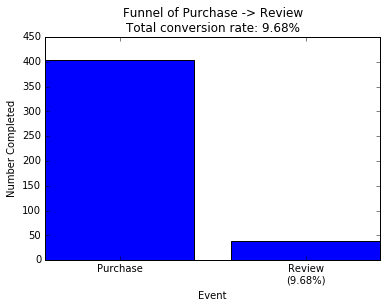

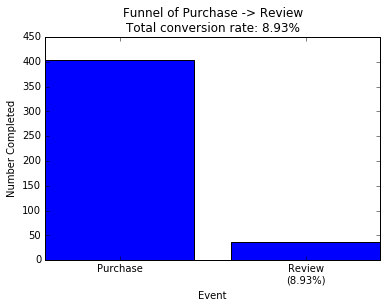

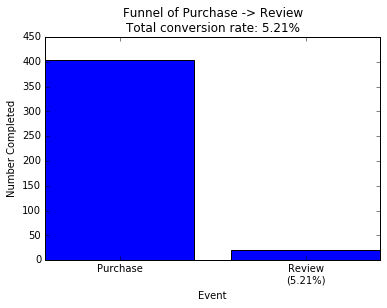

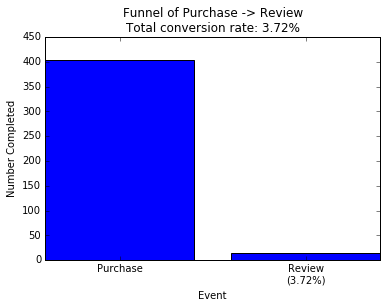

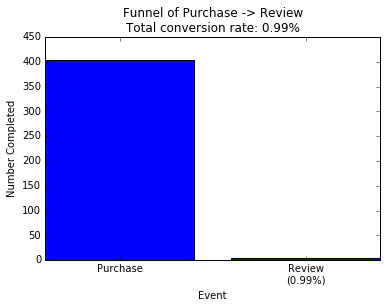

In [12]:
def make_funnel(events, conn, bound=None):
    """ Fetches data from the db and plots the resulting funnel
    
    Args:
        events (list): The events in the funnel
        conn (sqlite3.Connection) : Connection object corresponding to the database
    """
    user_events = get_events(events, conn)
    if bound:
        time_bound_for_user = partial(time_bounded_funnel_events_for_user, bound=bound)
        num_completed = funnel_events(user_events, len(events), time_bound_for_user)
    else:
        num_completed = funnel_events(user_events, len(events), funnel_events_for_user)
    funnel_plt(events, num_completed)

make_funnel(['Purchase', 'Review'], conn)
make_funnel(['Purchase', 'Review'], conn, 4900)
make_funnel(['Purchase', 'Review'], conn, 2000)
make_funnel(['Purchase', 'Review'], conn, 1000)
make_funnel(['Purchase', 'Review'], conn, 100)

We can see, as we'd expect, that as we lower our bound, less people will be have converted. In this particular example, we can use these funnels to determine when to email people asking them to review. Note that after 4,000 minutes (~3 days), if someone has made a purchase and hasn't filled out a review, it's very unlikely that they will on their own. Thus, this is a good point to start sending them an email. Using time-bounded funnels, we not only get a better sense of how people use our website, but also when they use it. 

## Path Analysis

Another import question we'd like to answer is: "of people who went from log-in to review, what was the most common step they did inbetween?"
This question about what path the user took is appropriate called a form of **path analysis**. There are more complicated questions, but for now we'll focus on answering this but implenting wild-card analysis, ie, graphing the funnel Log in -> \* -> \* -> Review will return a plot for each possible pair of events and how common they were.

First we need to find what events we have to choose from.

In [13]:
events = [row['event'] for row in conn.cursor().execute("""SELECT DISTINCT event FROM events""")]
print events

[u'Search', u'Purchase', u'Review', u'Log in', u'Sign up']


Next we need to iterate over all possible n-tuples and try them all. We'll do this by simply calling our existing funnel architecture on each possibility.

In [14]:
def calculate_paths(path, events, conn):
    """ Returns the funnel total for each path possible
    
    Args:
        path (list): A list of funnel steps with None standing in for a wildcard step
        events (list): A list of all events in the database
        conn (sqlite3.Connection) : Connection object corresponding to the database
    
    Returns:
        paths (list): A list of the wildcard paths
        counts (list): A list of the number of people who took the ith wildcard path
    """
    
    number_wildcards = len(filter(lambda step: step is None, path))
    wildcards = product(events, repeat=number_wildcards)
    
    def count_for_wildcard(wildcard):
        wildcard_list = list(wildcard)
        
        wildcard_path = [step or wildcard_list.pop() for step in path]
        
        wildcard_events = get_events(wildcard_path, conn)
        num_completed = funnel_events(wildcard_events, len(wildcard_path), funnel_events_for_user)
        return (wildcard, num_completed[-1])
    
    return map(count_for_wildcard, wildcards)

Now we just need to visualize this plot.

In [15]:
def path_analysis_plt(paths, funnel):
    """ Plots the different paths in descending order
    
    Args:
        paths (list): A list of (path, count) where count is the number of people 
                      who made it through that specific funnel
        funnel (list): A list of the steps of the funnel
    """
    funnel = [step or '*' for step in funnel] # Turn None into * to print
    
    paths = sorted(paths, key=lambda path: path[1], reverse=True) # Sorts by the count descending, not the path
    
    counts = map(lambda path: path[1], paths)
    wildcards = map(lambda path: path[0], paths)
    wildcard_labels = [', '.join(wildcard) for wildcard in wildcards]
    
    plt.bar(range(len(counts)), counts, BAR_WIDTH, color='blue')
    plt.xlabel('Path')
    plt.ylabel('Number Completed')

    plt.title('Most common paths of length {}\nfor funnel of {}'.format(len(wildcards[0]), ' -> '.join(funnel)))
    plt.xticks([i + BAR_WIDTH/2 for i in range(len(events))], wildcard_labels)

    plt.show()

Finally, we can write a nice wrapper to plot the path analysis from the initial funnel.

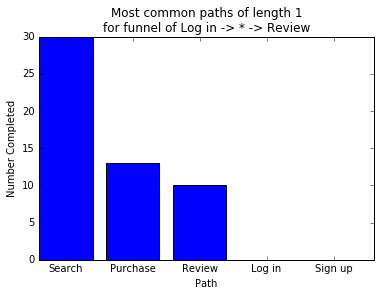

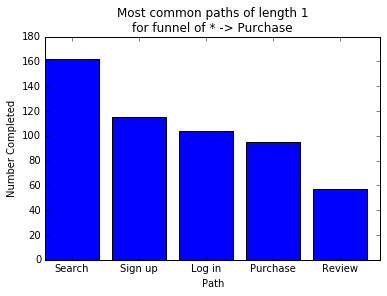

In [16]:
def path_analysis(path, events, conn):
    """ Generates and plots the possible paths and their counts given path

    Args:
        path (list): A list of funnel steps with None standing in for a wildcard step
        events (list): A list of all events in the database
        conn (sqlite3.Connection) : Connection object corresponding to the database    
    """
    
    paths = calculate_paths(path, events, conn)
    path_analysis_plt(paths, path)
    
path_analysis(['Log in', None, 'Review'], events, conn)
path_analysis([None, 'Purchase'], events, conn)

From this we can start to make some basic conclusions. From the first path analysis, we can see that of people who log in, do something, and review, most search. Which implies that people tend to log in with the _intent_ to review, instead of reviewing after making a purchase.

From the second path analysis, we see that the last action before purchase is very rarely reviewing, which makes sense, but is also very rarely purchasing. This could imply that if we have some kind of recommendation system after purchases that people aren't using it.

Path analysis is a very powerful tool, and there are much more questions to answer than this very basic question I answered here, for example, paths of bounded length, meaning "How people who signed up, purchased something no more than 5 actions later?", or "What kinds of paths are taken by more than 40% of my users?". These are much more complicated questions and the algorithms used to generated answers are likewise much more complicated. But the basic framework is similar to what was presented here today. 

## Summary

Funnels are an immensely powerful tool for understanding how users interact with a series of events. As we've seen, even with very low granularity, general events, we have very quickly been able to get an understanding of the problems facing a hypothetical website. Combining general funnels, time-bounded funnels, and path-analysis allows data scientists to gain a deep understanding of user interaction in a variety of situations. 